# Quiz 1 Nicolas Ruffing

In [63]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm

## 1 (a)

In [85]:
data = pd.read_csv("Stocks.csv", index_col=0)

# Cleaning the data
data.columns = data.columns.str.strip().str.replace('\ufeff', '')
data.index = pd.to_datetime(data.index, format='%d.%m.%Y')
stock_data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)
dher_prices = stock_data['DHER']
stock_data, data

(         TUI   DHER     TMV
 0    16.4907  98.86  12.625
 1    17.7507  92.50  11.950
 2    17.9249  89.76  11.845
 3    17.8552  84.86  11.600
 4    17.9481  85.10  11.395
 ..       ...    ...     ...
 890   7.4180  22.97   9.555
 891   7.7060  23.96   9.485
 892   7.6460  23.77   9.435
 893   7.6200  23.67   9.670
 894   7.5120  22.98   9.650
 
 [895 rows x 3 columns],
                 TUI   DHER     TMV
 Date                              
 2025-07-04   7.5120  22.98   9.650
 2025-07-03   7.6200  23.67   9.670
 2025-07-02   7.6460  23.77   9.435
 2025-07-01   7.7060  23.96   9.485
 2025-06-30   7.4180  22.97   9.555
 ...             ...    ...     ...
 2022-01-07  17.9481  85.10  11.395
 2022-01-06  17.8552  84.86  11.600
 2022-01-05  17.9249  89.76  11.845
 2022-01-04  17.7507  92.50  11.950
 2022-01-03  16.4907  98.86  12.625
 
 [895 rows x 3 columns])

In [65]:
# ln(P_t / P_{t-1})
log_returns = np.log(dher_prices / dher_prices.shift(1))
daily_volatility = log_returns.std()
daily_volatility_percent = daily_volatility * 100
print(f"daily log- returns vola DHER is: {daily_volatility_percent:.2f}%")


daily log- returns vola DHER is: 4.37%


## 1 (b)

In [74]:
# scaling factors
numTradingDays = 252
numCalenderDays = 360 

vol_cal_day = daily_volatility * 100
vola_trading_year = daily_volatility * np.sqrt(numTradingDays)
vola_calendar_year = daily_volatility * np.sqrt(numCalenderDays)

print(f"daily log- returns vola DHER is: {vol_cal_day:.2f}%")
print(f"annual log- returns vola DHER (trading days) is: {vola_trading_year *100:.2f}%")
print(f"annual log- returns vola DHER (calendar days) is: {vola_calendar_year *100:.2f}%")

daily log- returns vola DHER is: 4.37%
annual log- returns vola DHER (trading days) is: 69.38%
annual log- returns vola DHER (calendar days) is: 82.92%


## 2 (a)

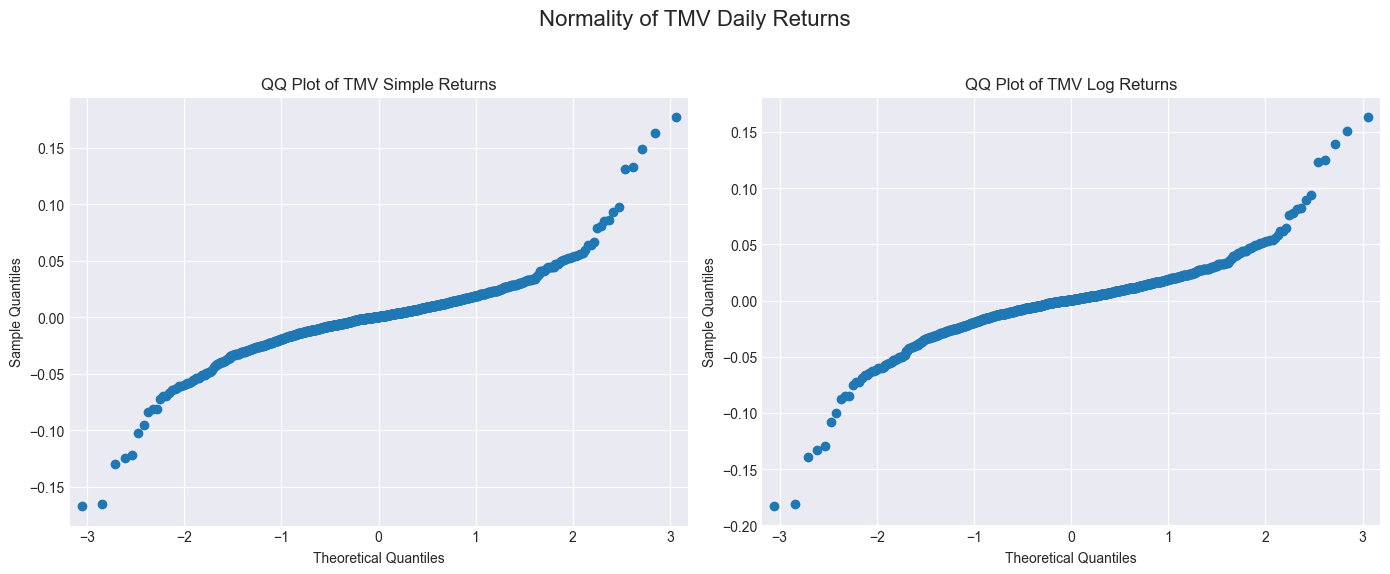

In [76]:
tmv_prices = stock_data['TMV']

# (P_t - P_{t-1}) / P_{t-1}
simple_ret_tmv = tmv_prices.pct_change().dropna()

# ln(P_t / P_{t-1})
log_returns_tmv = np.log(tmv_prices / tmv_prices.shift(1)).dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sm.qqplot(simple_ret_tmv, ax=axes[0])
axes[0].set_title('QQ Plot of TMV Simple Returns')
axes[0].set_xlabel('Theoretical Quantiles')
axes[0].set_ylabel('Sample Quantiles')

sm.qqplot(log_returns_tmv, ax=axes[1])
axes[1].set_title('QQ Plot of TMV Log Returns')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')

fig.suptitle('Normality of TMV Daily Returns', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

## 2 (b)

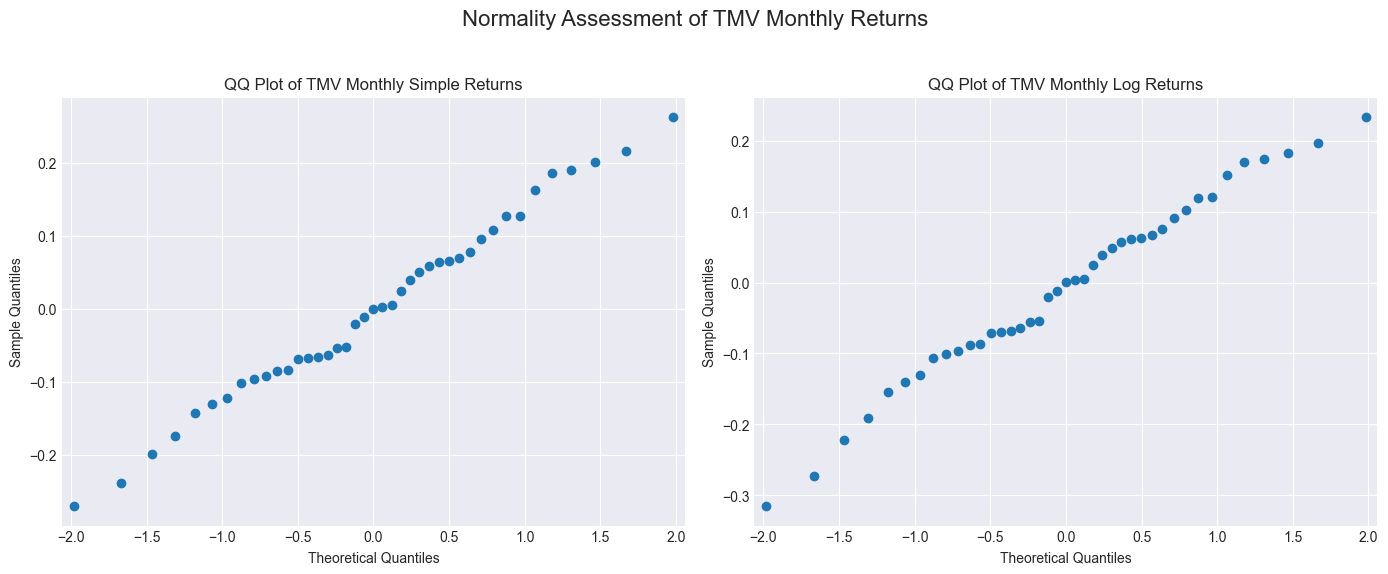

In [81]:
tmv_prices_monthly = data['TMV'].resample('ME').last()
tmv_prices_monthly = tmv_prices_monthly.loc['2022-01-01':'2025-06-30']

simple_returns_monthly = tmv_prices_monthly.pct_change().dropna()
log_returns_monthly = np.log(tmv_prices_monthly / tmv_prices_monthly.shift(1)).dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sm.qqplot(simple_returns_monthly, ax=axes[0])
axes[0].set_title('QQ Plot of TMV Monthly Simple Returns')
axes[0].set_xlabel('Theoretical Quantiles')
axes[0].set_ylabel('Sample Quantiles')

sm.qqplot(log_returns_monthly, ax=axes[1])
axes[1].set_title('QQ Plot of TMV Monthly Log Returns')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')

fig.suptitle('Normality Assessment of TMV Monthly Returns', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [80]:
tmv_prices, data

(0      12.625
 1      11.950
 2      11.845
 3      11.600
 4      11.395
         ...  
 890     9.555
 891     9.485
 892     9.435
 893     9.670
 894     9.650
 Name: TMV, Length: 895, dtype: float64,
                 TUI   DHER     TMV
 Date                              
 2025-07-04   7.5120  22.98   9.650
 2025-07-03   7.6200  23.67   9.670
 2025-07-02   7.6460  23.77   9.435
 2025-07-01   7.7060  23.96   9.485
 2025-06-30   7.4180  22.97   9.555
 ...             ...    ...     ...
 2022-01-07  17.9481  85.10  11.395
 2022-01-06  17.8552  84.86  11.600
 2022-01-05  17.9249  89.76  11.845
 2022-01-04  17.7507  92.50  11.950
 2022-01-03  16.4907  98.86  12.625
 
 [895 rows x 3 columns])

## 3 (a)

In [86]:
returns = stock_data.pct_change()
returns = returns.dropna()
correlation_matrix = returns.corr()

print("--- Correlation Matrix (Decimal) ---")
print(correlation_matrix)
print("\n" + "="*40 + "\n")


corr_tui_dher = correlation_matrix.loc['TUI', 'DHER']
corr_tui_tmv = correlation_matrix.loc['TUI', 'TMV']
corr_dher_tmv = correlation_matrix.loc['DHER', 'TMV']


print("--- Pairwise Correlations (Percentage) ---")
print(f"Correlation between TUI and DHER: {corr_tui_dher * 100:.1f}%")
print(f"Correlation between TUI and TMV: {corr_tui_tmv * 100:.1f}%")
print(f"Correlation between DHER and TMV: {corr_dher_tmv * 100:.1f}%")


--- Correlation Matrix (Decimal) ---
           TUI      DHER       TMV
TUI   1.000000  0.333600  0.270776
DHER  0.333600  1.000000  0.321433
TMV   0.270776  0.321433  1.000000


--- Pairwise Correlations (Percentage) ---
Correlation between TUI and DHER: 33.4%
Correlation between TUI and TMV: 27.1%
Correlation between DHER and TMV: 32.1%


## 3 (b)

In [ ]:

cov_matrix = returns.cov()
print(cov_matrix)

inv_cov_matrix = np.linalg.inv(cov_matrix)
ones_vector = np.ones(len(data.columns))
numerator = inv_cov_matrix.dot(ones_vector)

denominator = ones_vector.T.dot(inv_cov_matrix).dot(ones_vector)

mvp_weights_decimal = numerator / denominator

mvp_weights = pd.Series(mvp_weights_decimal, index=data.columns)

print(" Minimum-Variance Portfolio Weights")

mvp_weights_percent = mvp_weights * 100

print(f"TUI:  {mvp_weights_percent['TUI']:.1f}%")
print(f"DHER: {mvp_weights_percent['DHER']:.1f}%")
print(f"TMV:  {mvp_weights_percent['TMV']:.1f}%")

           TUI      DHER       TMV
TUI   0.000910  0.000437  0.000227
DHER  0.000437  0.001885  0.000388
TMV   0.000227  0.000388  0.000774
 Minimum-Variance Portfolio Weights
TUI:  40.8%
DHER: 7.6%
TMV:  51.6%


## 3 (c)

In [96]:
mean_returns = returns.mean()
    
# expected daily return of the portfolio 
portfolio_return = mvp_weights_decimal.T.dot(mean_returns)
portfolio_variance = mvp_weights_decimal.T.dot(cov_matrix).dot(mvp_weights_decimal)

portfolio_std_dev = np.sqrt(portfolio_variance)

print("MVP Return and Standard Deviation")

portfolio_return_percent = portfolio_return * 100
portfolio_std_dev_percent = portfolio_std_dev * 100

print(f"Return:            {portfolio_return_percent:.2f}%")
print(f"Standard deviation:  {portfolio_std_dev_percent:.2f}%")
    

MVP Return and Standard Deviation
Return:            -0.02%
Standard deviation:  2.28%


## 3 (d)

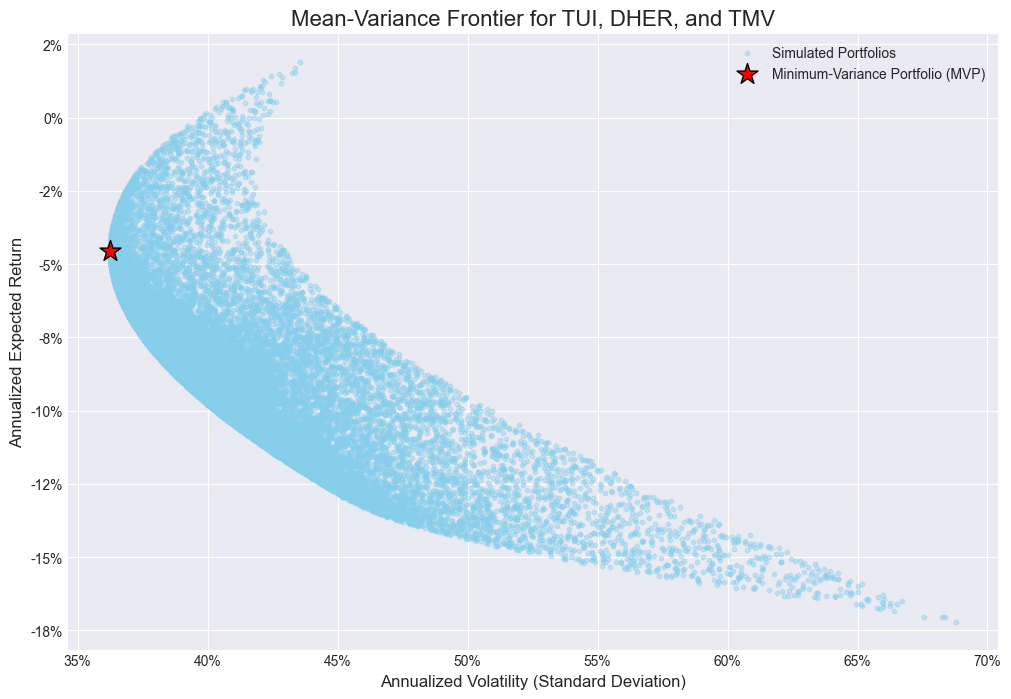

In [104]:
trading_days = 252
mean_returns_annual = returns.mean() * trading_days
cov_matrix_annual = returns.cov() * trading_days

num_portfolios = 20000
portfolio_returns = []
portfolio_volatilities = []

for i in range(num_portfolios):
    weights = np.random.random(len(stock_data.columns))
    weights /= np.sum(weights)
    port_return = np.sum(mean_returns_annual * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))
    portfolio_returns.append(port_return)
    portfolio_volatilities.append(port_volatility)

cov_matrix_daily = log_returns.cov()
inv_cov_matrix = np.linalg.inv(cov_matrix_daily)
ones_vector = np.ones(len(stock_data.columns))

numerator = inv_cov_matrix.dot(ones_vector)
denominator = ones_vector.T.dot(inv_cov_matrix).dot(ones_vector)
mvp_weights = numerator / denominator


mvp_return = np.sum(mean_returns_annual * mvp_weights)
mvp_volatility = np.sqrt(np.dot(mvp_weights.T, np.dot(cov_matrix_annual, mvp_weights)))


plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 8))
plt.scatter(portfolio_volatilities, portfolio_returns, c='skyblue', marker='o', s=10, alpha=0.4, label='Simulated Portfolios')
plt.scatter(mvp_volatility, mvp_return, c='red', marker='*', s=250, edgecolors='black', label='Minimum-Variance Portfolio (MVP)')
plt.title('Mean-Variance Frontier for TUI, DHER, and TMV', fontsize=16)
plt.xlabel('Annualized Volatility (Standard Deviation)', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))

plt.legend()
plt.show()

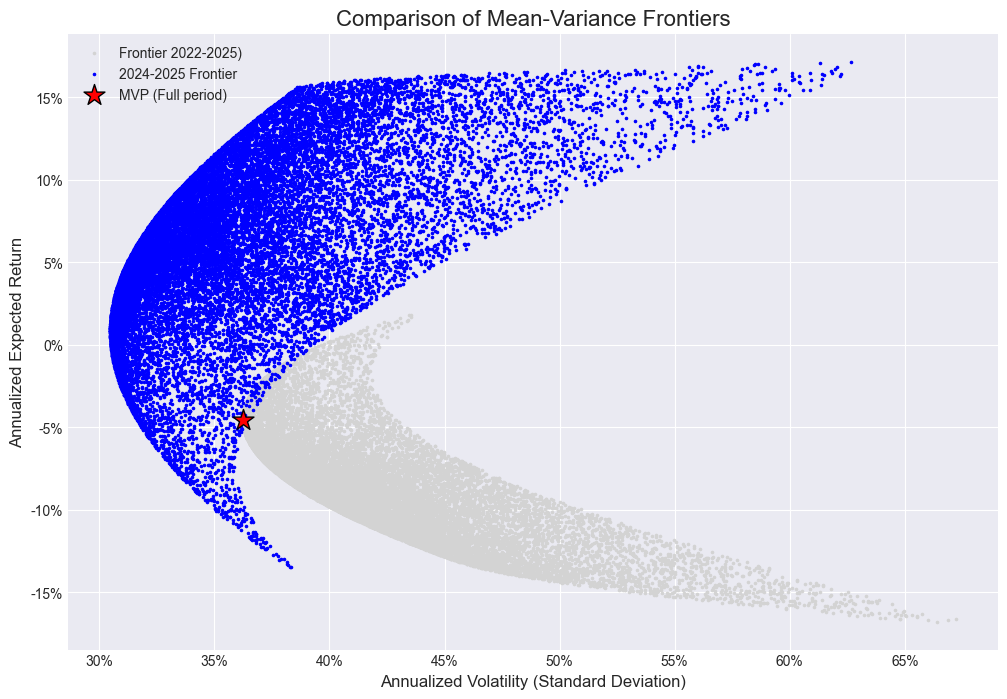

In [103]:
start_date = "2024-01-05"
stock_data_2024 = data[data.index >= pd.to_datetime(start_date)]
stock_data_2024 = stock_data_2024.sort_values(by='Date', ascending=True).reset_index(drop=True)
returns_2024 = stock_data_2024.pct_change().dropna()

mean_returns_annual_2024 = returns_2024.mean() * trading_days
cov_matrix_annual_2024 = returns_2024.cov() * trading_days

portfolio_returns_2024 = []
portfolio_volatilities_2024 = []

for i in range(num_portfolios):
    weights = np.random.random(len(stock_data.columns))
    weights /= np.sum(weights)
    port_return = np.sum(mean_returns_annual_2024 * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual_2024, weights)))
    portfolio_returns_2024.append(port_return)
    portfolio_volatilities_2024.append(port_volatility)

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 8))
plt.scatter(portfolio_volatilities, portfolio_returns, c='lightgray', marker='.', s=10, label='Frontier 2022-2025)')
plt.scatter(portfolio_volatilities_2024, portfolio_returns_2024, c='blue', marker='.', s=10, label='2024-2025 Frontier')
plt.scatter(mvp_volatility, mvp_return, c='red', marker='*', s=250, edgecolors='black', label='MVP (Full period)')
plt.title('Comparison of Mean-Variance Frontiers', fontsize=16)
plt.xlabel('Annualized Volatility (Standard Deviation)', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.legend()
plt.show()

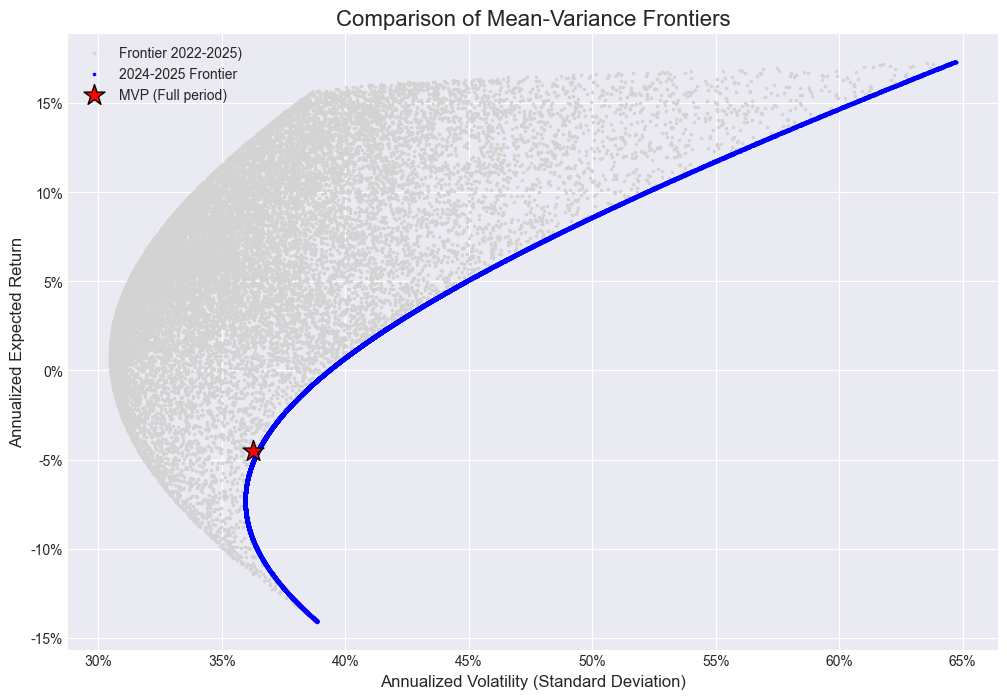

In [122]:
start_date = "2024-01-05"
stock_data_2024_2assets = data[data.index >= pd.to_datetime(start_date)]
stock_data_2024_2assets = stock_data_2024_2assets[['DHER', 'TMV']]
stock_data_2024_2assets = stock_data_2024_2assets.sort_values(by='Date', ascending=True).reset_index(drop=True)
returns_2024_2assets = stock_data_2024_2assets.pct_change().dropna()

mean_returns_annual_2024_2assets = returns_2024_2assets.mean() * trading_days
cov_matrix_annual_2024_2assets = returns_2024_2assets.cov() * trading_days

portfolio_returns_2024_2assets = []
portfolio_volatilities_2024_2assets = []

for i in range(num_portfolios):
    weights = np.random.random(len(stock_data_2024_2assets.columns))
    weights /= np.sum(weights)
    port_return = np.sum(mean_returns_annual_2024_2assets * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual_2024_2assets, weights)))
    portfolio_returns_2024_2assets.append(port_return)
    portfolio_volatilities_2024_2assets.append(port_volatility)


plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 8))
plt.scatter(portfolio_volatilities_2024, portfolio_returns_2024, c='lightgray', marker='.', s=10, label='Frontier 2022-2025)')
plt.scatter(portfolio_volatilities_2024_2assets, portfolio_returns_2024_2assets, c = "blue",marker='.', s=10, label='2024-2025 Frontier')
plt.scatter(mvp_volatility, mvp_return, c='red', marker='*', s=250, edgecolors='black', label='MVP (Full period)')
plt.title('Comparison of Mean-Variance Frontiers', fontsize=16)
plt.xlabel('Annualized Volatility (Standard Deviation)', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.legend()
plt.show()

In [117]:
weights

array([0.55607696, 0.44392304])